# Exploring the effect of class imbalance on model performance

Starting with the Titanic dataset as a balanced one, we will make the training data more and more imbalanced to show the effects of trying to train with fewer and fewer positive samples.

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

from src.preprocessing import preprocessor_pipeline, rebalance_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
)

%load_ext lab_black

In [2]:
with open("src/params.json", "r") as file:
    model_params = json.load(file)

In [4]:
params = model_params["model_parameters"]

## Load data and split into train/val

In [5]:
train_df = pd.read_csv("data/train.csv")

train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=1, stratify=train_df["Survived"]
)
train_df, val_df = (train_df.copy(), val_df.copy())

In [6]:
label = "Survived"

# Main training loop

In [64]:
ratios = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4, 5, 10]
ratios = np.array([np.around(0.1 * x, decimals=1) for x in range(10, 101)])

In [66]:
df_dict = dict()

X_train_dict = dict()
y_train_dict = dict()
model_dict = dict()
scores_dict = dict()
metrics_list = list()

# instantiate the preprocessor
preprocessor = preprocessor_pipeline(scaling=True)

# define feature types
categorical_fts = ["Pclass", "Embarked", "Sex"]
numerical_fts = ["Age", "Fare"]
input_features = numerical_fts + categorical_fts

for ratio in ratios:
    df_balanced = rebalance_dataset(train_df, label, ratio)
    df_dict[ratio] = df_balanced
    print(f"Ratio {ratio} - df shape {df_dict[ratio].shape}")

    # transform the data
    X_train_dict[ratio] = preprocessor.fit_transform(df_balanced[input_features])
    y_train_dict[ratio] = df_balanced[label].values

    # sort out the validation data
    val_tf = preprocessor.transform(val_df[input_features])
    val_y = val_df[label].values

    # train the model
    clf = RandomForestClassifier(**params)
    trained_model = clf.fit(X_train_dict[ratio], y_train_dict[ratio])
    model_dict[ratio] = trained_model

    # get the scores
    scores = clf.predict_proba(val_tf)[:, 1]
    scores_dict[ratio] = scores
    # get the true values
    y_hat = np.where(scores, 1, 0)

    # get all the metrics on the model
    metrics = {
        "model_ratio": [ratio],
        "accuracy": [accuracy_score(val_y, y_hat)],
        "precision": [precision_score(val_y, y_hat)],
        "recall": [recall_score(val_y, y_hat)],
    }

    metrics_df = pd.DataFrame.from_dict(data=metrics, orient="columns")
    metrics_list.append(metrics_df)

metrics_df = pd.concat(metrics_list)
metrics_df.to_csv("data/metrics.csv", index=False)
with open("data/scores.json", "w") as f:
    json.dump({k: scores_dict[k].tolist() for k in scores_dict.keys()}, f)
    

In [111]:
true_df = pd.DataFrame(val_y, columns=["true"])
true_df.to_csv("data/true.csv", index=False)

In [67]:
print(classification_report(val_y, y_hat))
print(confusion_matrix(val_y, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.55      0.70        55
           1       0.58      0.97      0.72        35

    accuracy                           0.71        90
   macro avg       0.77      0.76      0.71        90
weighted avg       0.82      0.71      0.71        90

[[30 25]
 [ 1 34]]


In [68]:
metrics_df

,model_ratio,accuracy,precision,recall
0,1.0,0.411111,0.395349,0.971429
0,1.1,0.422222,0.400000,0.971429
0,1.2,0.444444,0.409639,0.971429
0,1.3,0.400000,0.388235,0.942857
0,1.4,0.411111,0.395349,0.971429
...,...,...,...,...
0,9.6,0.633333,0.516667,0.885714
0,9.7,0.655556,0.534483,0.885714
0,9.8,0.655556,0.534483,0.885714
0,9.9,0.744444,0.615385,0.914286


In [108]:
scores_df = pd.DataFrame(scores_dict[1.0], columns=["proba"])
scores_df = pd.merge(left=scores_df, right=true_df, left_index=True, right_index=True)

(array([10.,  9.,  7.,  4.,  3.,  5.,  4.,  0.,  1.,  2.,  0.,  1.,  2.,
         2.,  0.,  0.,  3.,  0.,  1.,  1.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

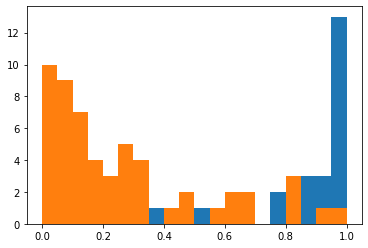

In [114]:
plt.hist(
    scores_df.query("true==1")["proba"],
    bins=[0.05 * x for x in range(21)],
    label="Negative",
)
plt.hist(
    scores_df.query("true==0")["proba"],
    bins=[0.05 * x for x in range(21)],
    label="Positive",
)